In [149]:
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import xgboost as xgb

# from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Normalizer, FunctionTransformer, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, shapiro, probplot
import category_encoders as ce

In [2]:
train_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/train_set_01_featurized.parquet.gzip"
)
test_data = pd.read_parquet(
    "../data/processed/chrome/08_12_2022/test_set_01_featurized.parquet.gzip"
)

In [9]:
train_data

,content-type,accept-ranges,etag,vary,content-encoding,cache-control,expires,content-length,server,age,...,etag_length,access-control-allow-origin_cumulative,pragma_binary,p3p_binary,x-xss-protection_binary,x-content-type-options_binary,strict-transport-security_binary,access-control-allow-credentials_binary,timing-allow-origin_binary,tracker
0,text/javascript; charset=utf-8,Missing,15601544113783900868,accept-encoding,gzip,"public, max-age=1209600","fri, 26 aug 2022 11:22:22 gmt",13475,cafe,5806.0,...,20,Missing,0,1,1,1,0,0,1,1
1,application/javascript,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,max-age=630720000,"thu, 31 dec 2037 23:55:55 gmt",4768,nginx,90752.0,...,-1,*,0,0,0,1,1,0,1,0
2,image/gif,Missing,Missing,accept-encoding,gzip,"no-cache, no-store, must-revalidate","fri, 01 jan 1990 00:00:00 gmt",42,cafe,-1.0,...,-1,Missing,1,1,1,1,0,0,1,1
3,image/jpeg,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,no-store,"thu, 31 dec 2037 23:55:55 gmt",0,nginx,90752.0,...,-1,*,1,0,0,0,0,0,1,0
4,text/html; charset=utf-8,bytes,0x8da7b64a03a8ae5,accept-encoding,gzip,"private, max-age=0","sun, 01 feb 1970 00:00:00 gmt",7461,nginx,90752.0,...,-1,Missing,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,image/png,bytes,"""618df712-2509""",accept-encoding,gzip,max-age=31622400,"thu, 03 aug 2023 14:44:48 gmt",9481,nginx,845572.0,...,15,Missing,0,0,0,0,1,0,0,0
272000,image/gif,Missing,Missing,accept-encoding,gzip,"no-store, no-cache, must-revalidate, max-age=0","mon, 04 dec 1999 21:29:02 gmt",49,cafe,-1.0,...,-1,*,1,0,0,1,0,0,1,1
272001,binary/octet-stream,bytes,"""4abfa4888190370d347034f9fa43c804""","accept-encoding,origin",gzip,max-age=31536000,"thu, 31 dec 2037 23:55:55 gmt",57064,amazons3,709890.0,...,34,Other,0,0,0,0,0,1,0,0
272002,application/xml,bytes,"""29a-1630333f5d8""","x-edge-forwarded-proto, x-forwarded-host, acce...",gzip,"public, max-age=86400","thu, 31 dec 2037 23:55:55 gmt",666,nginx,28523.0,...,17,Missing,0,0,1,1,1,0,0,0


In [7]:
def check_distribution(dataset, feature):
    values = dataset[dataset[feature].notnull()][feature]
    sample_size = {5001: 1067, 5000: 880, 2500: 748, 1000: 516, 500: 341, 200: 169}
    sample_values = [v for v in sample_size.keys() if len(values) > v]
    if len(sample_values) == 0:
        n = int(len(values) * 0.1)
    else:
        n = sample_size[sample_values[0]]
    feature_values = values.sample(n=n, random_state=10).to_numpy().astype(np.int64)
    stat, p_value = shapiro(feature_values)  # kstest(feature_values, 'norm')
    return stat, p_value

In [10]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [ ]:
# scale content-length and age

In [12]:
train_data.dtypes

content-type                               category
accept-ranges                              category
etag                                       category
vary                                       category
content-encoding                           category
                                             ...   
x-content-type-options_binary                 int64
strict-transport-security_binary              int64
access-control-allow-credentials_binary       int64
timing-allow-origin_binary                    int64
tracker                                       uint8
Length: 153, dtype: object

In [148]:
%%time
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=10)
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_train, y_train)

CPU times: user 20.1 ms, sys: 1.17 ms, total: 21.3 ms
Wall time: 20.1 ms


0.7157431508360171

In [89]:
numeric_transformer = Pipeline(
    steps=[("scaler", FunctionTransformer(np.log1p))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['content-length']),
        ('cat', ce.WOEEncoder(), selector(dtype_include='category'))
    ]
)

In [117]:
clf = Pipeline(
    steps=[('preprocessor', preprocessor), ('classifier', RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                                                                 random_state=10,
                                                                                 criterion='log_loss',
                                                                                 max_features=None))]
)

In [118]:
clf.fit(X_train, y_train['tracker'].to_numpy())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                  ['content-length']),
                                                 ('cat', WOEEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fe00c55b5b0>)])),
                ('classifier',
                 RandomForestClassifier(criterion='log_loss', max_features=None,
                                        n_jobs=-1, random_state=10))])

In [119]:
clf.score(X_test, y_test)

0.9995147130189261

In [120]:
y_pred = clf.predict(X_test)
print('Model accuracy score : {0:0.4f}'. format(metrics.accuracy_score(y_test, y_pred)))

Model accuracy score : 0.9995


In [121]:
clf_probs = clf.predict_proba(X_test)
score = metrics.log_loss(y_test, clf_probs)
print('Model log-loss score : {0:0.4f}'. format(score))

Model log-loss score : 0.0015


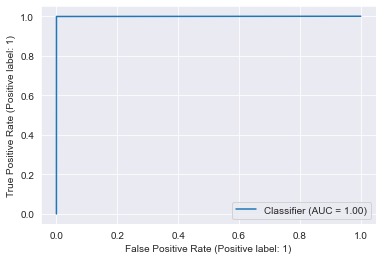

In [136]:
metrics.RocCurveDisplay.from_predictions(y_test, y_pred)

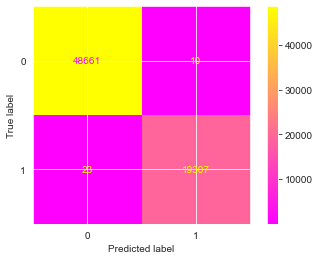

In [141]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='spring')
# TN FP
# FN TP

In [150]:
%%time
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

Accuracy: 1.000 (0.000)
CPU times: user 883 ms, sys: 564 ms, total: 1.45 s
Wall time: 57.6 s


In [122]:
importance = clf['classifier'].feature_importances_
# d = {"header": X_train.columns.values.tolist(), "value": importance.tolist()}

In [113]:
feature_names = [f"feature {i}" for i in range(X_train.shape[1])]
forest_importances = pd.Series(importance, index=feature_names)

fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

ValueError: Length of values (12) does not match length of index (152)

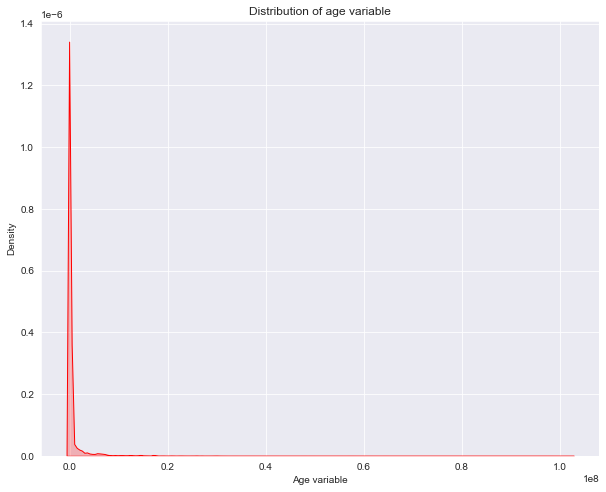

In [107]:
f, ax = plt.subplots(figsize=(10,8))
x = X_train['age']
x = pd.Series(x, name="Age variable")
ax = sns.kdeplot(x, shade=True, color='red')
ax.set_title("Distribution of age variable")
plt.show()